# CNN2b SETTINGS

SUBJECT'S DATA SELECTION:                                                                                                  
- **A**: Signal samples: 7794, EEG channels: 64, Testset letters: 100                                                           
- **B**: Signal samples: 7794, EEG channels: 64, Testset letters: 100 

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np     
import random           
from scipy.io import loadmat
from scipy import signal
from google.colab import drive
import warnings
import string
import os

from keras.layers import *
from keras.models import Model
from keras import backend as K
from keras import Sequential
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

# Install mne library for topoplot
!pip install mne
import mne

warnings.filterwarnings('ignore')
drive.mount('/content/drive')

####################### SETTINGS ########################
# Set this variable with the desidered subject's letter #
SUBJECT_SELECTED = "B"                                  #
#########################################################

subject_names = ["A", "B"]

# Check for errors in the settings
if SUBJECT_SELECTED not in subject_names:
    raise ValueError("SUBJECT_SELECTED value {} is invalid.\nPlease enter one of the following parameters {}".format(SUBJECT_SELECTED, subject_names))

# Google drive data paths
MODEL_LOCATIONS_FILE_PATH = 'drive/My Drive/AY1920_DT_P300_SPELLER_03/Trained_models/CNN2b/' + SUBJECT_SELECTED
SUBJECT_TRAIN_FILE_PATH = 'drive/My Drive/AY1920_DT_P300_SPELLER_03/Dataset/Subject_' + SUBJECT_SELECTED + '_Train.mat'
SUBJECT_TEST_FILE_PATH = 'drive/My Drive/AY1920_DT_P300_SPELLER_03/Dataset/Subject_' + SUBJECT_SELECTED + '_Test.mat'
CHANNEL_LOCATIONS_FILE_PATH = 'drive/My Drive/AY1920_DT_P300_SPELLER_03/Dataset/channels.csv'
CHANNEL_COORD = 'drive/My Drive/AY1920_DT_P300_SPELLER_03/Dataset/coordinates.csv'

# 8 channels are obtained by selection of first layer in CNN1
if SUBJECT_SELECTED == "A":
    CHANNELS = [10, 14, 17, 50, 55, 57, 59, 60]
elif SUBJECT_SELECTED == "B":
    CHANNELS = [17, 50, 55, 56, 57, 58, 59, 60]

Using TensorFlow backend.


     |████████████████████████████████| 6.4MB 30.2MB/s 


/usr/local/lib/python3.6/dist-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Training set processing

1.   Application of bandpass filter **(0.1-20Hz)**;
2.   Down-sampling signals from 240Hz to 120Hz;
3.   Obtain windows of 650ms at the start of every flashing (175ms)
4.   Normalization of samples in each window: **Zi = (Xi - mu) / sigma**;
5.   Reshape each window to be a 3D tensor with dimensions: **(N_SAMPLES, 78, 8)**;
6.   Obtain **(noP300 / P300)** class ratio to balance out dataset during training;










In [0]:
if not os.path.exists(SUBJECT_TRAIN_FILE_PATH):
    print("Missing file: {}".format(SUBJECT_TRAIN_FILE_PATH))
else:
    # Load the required data
    data = loadmat(SUBJECT_TRAIN_FILE_PATH)
    # Get the variables of interest from the loaded dictionary
    signals = data['Signal']
    # Take only the 8 selected channels of the signal
    signals = signals[:, :, CHANNELS]
    
    flashing = data['Flashing']
    stimulus = data['StimulusType']
    word = data['TargetChar']
    
    SAMPLING_FREQUENCY = 240
    # From the dataset description we know that there are 15 repetitions
    REPETITIONS = 15
    # Compute the duration of the recording in minutes
    RECORDING_DURATION = (len(signals))*(len(signals[0]))/(SAMPLING_FREQUENCY*60)
    # Compute number of trials
    TRIALS = len(word[0])
    # Set flag to True to balance the training set
    BALANCE_DATASET = False

    print("**********************************")
    print("       TRAIN SET INFORMATION      ")
    print("**********************************")
    print("Sampling Frequency: %d Hz [%.2f ms]" % (SAMPLING_FREQUENCY, (1000/SAMPLING_FREQUENCY)))
    print("Session duration:   %.2f min" % RECORDING_DURATION)
    print("Number of letters:  %d" % TRIALS)
    print("Spelled word:       %s" % ''.join(word))

**********************************
       TRAIN SET INFORMATION      
**********************************
Sampling Frequency: 240 Hz [4.17 ms]
Session duration:   46.01 min
Number of letters:  85
Spelled word:       VGREAAH8TVRHBYN_UGCOLO4EUERDOOHCIFOMDNU6LQCPKEIREKOYRQIDJXPBKOJDWZEUEWWFOEBHXTQTTZUMO


In [0]:
# Application of butterworth filter
b, a = signal.butter(4, [0.1/SAMPLING_FREQUENCY, 20/SAMPLING_FREQUENCY], 'bandpass')
for trial in range(TRIALS):
    signals[trial, :, :] = signal.filtfilt(b, a, signals[trial, :, :], axis=0)

In [0]:
# Down-sampling of the signals from 240Hz to 120Hz
DOWNSAMPLING_FREQUENCY = 120
SCALE_FACTOR = round(SAMPLING_FREQUENCY / DOWNSAMPLING_FREQUENCY)
SAMPLING_FREQUENCY = DOWNSAMPLING_FREQUENCY

print("# Samples of EEG signals before downsampling: {}".format(len(signals[0])))

signals = signals[:, 0:-1:SCALE_FACTOR, :]
flashing = flashing[:, 0:-1:SCALE_FACTOR]
stimulus = stimulus[:, 0:-1:SCALE_FACTOR]

print("# Samples of EEG signals after downsampling: {}".format(len(signals[0])))

# Samples of EEG signals before downsampling: 7794
# Samples of EEG signals after downsampling: 3897


In [0]:
# Number of EEG channels
N_CHANNELS = len(CHANNELS)
# Window duration after each flashing [ms]
WINDOW_DURATION = 650
# Number of samples of each window
WINDOW_SAMPLES = round(SAMPLING_FREQUENCY * (WINDOW_DURATION / 1000))
# Number of samples for each character in trials
SAMPLES_PER_TRIAL = len(signals[0])

train_features = []
train_labels = []

count_positive = 0
count_negative = 0

for trial in range(TRIALS):
    for sample in (range(SAMPLES_PER_TRIAL)):
        if (sample == 0) or (flashing[trial, sample-1] == 0 and flashing[trial, sample] == 1):
            lower_sample = sample
            upper_sample = sample + WINDOW_SAMPLES
            window = signals[trial, lower_sample:upper_sample, :]                
            # Features extraction
            train_features.append(window)
            # Labels extraction
            if stimulus[trial, sample] == 1:
                count_positive += 1
                train_labels.append(1) # Class P300
            else:
                count_negative += 1
                train_labels.append(0) # Class no-P300

# Get negative-positive classes ratio
train_ratio = count_negative/count_positive

# Convert lists to numpy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)

# 3D Tensor shape (SAMPLES, 78, 8)
dim_train = train_features.shape
print("Features tensor shape: {}".format(dim_train))

Features tensor shape: (15300, 78, 8)


In [0]:
# Data normalization Zi = (Xi - mu) / sigma
for pattern in range(len(train_features)):
    train_features[pattern] = scale(train_features[pattern], axis=0)

# Testing set processing

1.   Application of bandpass filter **(0.1-20Hz)**;
2.   Down-sampling signas from 240Hz to 120Hz;
3.   Obtain windows of 650ms at the start of every flashing (175ms)
4.   Normalization of samples in each window: **Zi = (Xi - mu) / sigma**;
5.   Reshape each window to be a 3D tensor with dimensions: **(N_SAMPLES, 78, 8)**;
6.   Calculate weights vector to balance samples importance and obtain correct accuracy estimation;

In [0]:
# Test data loading
if not os.path.exists(SUBJECT_TEST_FILE_PATH):
    print("Missing file: {}", SUBJECT_TEST_FILE_PATH)
else:
    # Load the required data
    data_test = loadmat(SUBJECT_TEST_FILE_PATH)
    # Get the variables of interest from the loaded dictionary
    signals_test = data_test['Signal']
    signals_test = signals_test[:, :, CHANNELS]
    flashing_test = data_test['Flashing']
    word_test =  data_test['TargetChar']
    stimulus_code_test = data_test['StimulusCode']

    SAMPLING_FREQUENCY = 240
    # From the dataset description we know that there are 15 repetitions
    REPETITIONS = 15
    # Compute the duration of the recording in minutes
    RECORDING_DURATION_TEST = (len(signals_test))*(len(signals_test[0]))/(SAMPLING_FREQUENCY*60)
    # Compute number of trials
    TRIALS_TEST = len(word_test[0])
    # Number of samples for each character in trials
    SAMPLES_PER_TRIAL_TEST = len(signals_test[0])
    
    print("**********************************")
    print("        TEST SET INFORMATION      ")
    print("**********************************")
    print("Sampling Frequency: %d Hz [%.2f ms]" % (SAMPLING_FREQUENCY, (1000/SAMPLING_FREQUENCY)))
    print("Session duration:   %.2f min" % RECORDING_DURATION_TEST)
    print("Number of letters:  %d" % TRIALS_TEST)
    print("Spelled word:       %s" % ''.join(word_test))

**********************************
        TEST SET INFORMATION      
**********************************
Sampling Frequency: 240 Hz [4.17 ms]
Session duration:   54.12 min
Number of letters:  100
Spelled word:       MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR


In [0]:
# Create characters matrix
char_matrix = [[0 for j in range(6)] for i in range(6)]
s = string.ascii_uppercase + '1' + '2' + '3' + '4' + '5' + '6' + '7' + '8' + '9' + '_'

# Append cols and rows in a list
list_matrix = []
for i in range(6):
    col = [s[j] for j in range(i, 36, 6)]
    list_matrix.append(col)
for i in range(6):
    row = [s[j] for j in range(i * 6, i * 6 + 6)]
    list_matrix.append(row)

# Create StimulusType array for the test set (missing from the given database)
stimulus_test = [[0 for j in range(SAMPLES_PER_TRIAL_TEST)] for i in range(TRIALS_TEST)]
stimulus_test = np.array(stimulus_test)

for trial in range(TRIALS_TEST):
    counter=0
    for sample in range(SAMPLES_PER_TRIAL_TEST):
        index = int(stimulus_code_test[trial, sample]) - 1
        if not index == -1:
            if word_test[0][trial] in list_matrix[index]:
                stimulus_test[trial, sample] = 1
            else:
                stimulus_test[trial, sample] = 0

In [0]:
# Application of butterworth filter
b, a = signal.butter(4, [0.1/SAMPLING_FREQUENCY, 20/SAMPLING_FREQUENCY], 'bandpass')
for trial in range(TRIALS_TEST):
    signals_test[trial, :, :] = signal.filtfilt(b, a, signals_test[trial, :, :], axis=0)

In [0]:
# Down-sampling of the signals from 240Hz to 120Hz
DOWNSAMPLING_FREQUENCY = 120
SCALE_FACTOR = round(SAMPLING_FREQUENCY / DOWNSAMPLING_FREQUENCY)
SAMPLING_FREQUENCY = DOWNSAMPLING_FREQUENCY

print("# Samples of EEG signals before downsampling: {}".format(len(signals_test[0])))

signals_test = signals_test[:, 0:-1:SCALE_FACTOR, :]
flashing_test = flashing_test[:, 0:-1:SCALE_FACTOR]
stimulus_test = stimulus_test[:, 0:-1:SCALE_FACTOR]

print("# Samples of EEG signals after downsampling: {}".format(len(signals_test[0])))

# Samples of EEG signals before downsampling: 7794
# Samples of EEG signals after downsampling: 3897


In [0]:
# Number of EEG channels
N_CHANNELS = len(CHANNELS)
# Window duration after each flashing [ms]
WINDOW_DURATION = 650
# Number of samples of each window
WINDOW_SAMPLES = round(SAMPLING_FREQUENCY * (WINDOW_DURATION / 1000))
# Number of samples for each character in trials
SAMPLES_PER_TRIAL_TEST = len(signals[0])

test_features = []
test_labels = []
windowed_stimulus = []

count_positive = 0
count_negative = 0

for trial in range(TRIALS_TEST):
    for sample in (range(SAMPLES_PER_TRIAL_TEST)):
        if (sample == 0) or (flashing_test[trial, sample-1] == 0 and flashing_test[trial, sample] == 1):
            lower_sample = sample
            upper_sample = sample + WINDOW_SAMPLES
            window = signals_test[trial, lower_sample:upper_sample, :]
            # Extracting number of row/col in a window
            number_stimulus = int(stimulus_code_test[trial, sample])
            windowed_stimulus.append(number_stimulus)
            # Features extraction
            test_features.append(window)
            # Labels extraction
            if stimulus_test[trial, sample] == 1:
                count_positive += 1
                test_labels.append(1) # Class P300
            else:
                count_negative += 1
                test_labels.append(0) # Class no-P300

# Get test weights to take into account the number of classes 
test_weights = []
for i in range(len(test_labels)):
    if test_labels[i] == 1:
        test_weights.append(len(test_labels)/count_positive)
    else:
        test_weights.append(len(test_labels)/count_negative)
test_weights = np.array(test_weights)

# Convert lists to numpy arrays
test_features = np.array(test_features)
test_labels = np.array(test_labels)

# 3D tensor (SAMPLES, 78, 64)
dim_test = test_features.shape
print("Features tensor shape: {}".format(dim_test))

Features tensor shape: (18000, 78, 8)


In [0]:
# Data normalization Zi = (Xi - mu) / sigma
for pattern in range(len(test_features)):
    test_features[pattern] = scale(test_features[pattern], axis=0)

# CNN2b model definition, training and testing

1.   Function definiton for randomization of weights and biases;
2.   **Scaled_tanh(x)** activation function definition;
3.   ANN model definition (2 Conv1D layers, 2 dense layers);
4.   Training of the network over weighted dataset;
5.   CNN2b performance assessment;

In [0]:
# Randomizing function for bias and weights of the network
def cecotti_normal(shape, dtype = None, partition_info = None):
    if len(shape) == 1:
        fan_in = shape[0]
    elif len(shape) == 2:
        fan_in = shape[0]
    else:
        receptive_field_size = 1
        for dim in shape[:-2]:
            receptive_field_size *= dim
        fan_in = shape[-2] * receptive_field_size
    return K.random_normal(shape, mean = 0.0, stddev = (1.0 / fan_in))

In [0]:
# Custom tanh activation function
def scaled_tanh(z):
    return 1.7159 * K.tanh((2.0 / 3.0) * z)

In [0]:
# Build the model
def CNN2b_model(channels=8, filters=10):
    model = Sequential([
        Conv1D(
            filters = filters,
            kernel_size = 1,
            padding = "same",
            bias_initializer = cecotti_normal,
            kernel_initializer = cecotti_normal,
            use_bias = True,
            activation = scaled_tanh,
            input_shape = (78, channels)
        ),
        Conv1D(
            filters = 50,
            kernel_size = 13,
            padding = "valid",
            strides = 11,
            bias_initializer = cecotti_normal,
            kernel_initializer = cecotti_normal,
            use_bias = True,
            activation = scaled_tanh,
        ),
        Flatten(),
        Dense(100, activation="sigmoid"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    return model

In [0]:
# Training parameters
BATCH_SIZE = 256
EPOCHS = 200
VALID_SPLIT = 0.05
SHUFFLE = 1 # set to 1 to shuffle subsets during training

# Model summary
CNN2b_model(channels=8, filters=10).summary()






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 78, 10)            90        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 50)             6550      
_________________________________________________________________
flatten_1 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 36,841
Trainable params: 36,841
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Model definition
model = CNN2b_model(channels=8, filters=10)

# Callback to save best model only
checkpoint = ModelCheckpoint(filepath=MODEL_LOCATIONS_FILE_PATH + "/" + "model" + ".h5", 
                             monitor='val_loss', 
                             mode='min',
                             save_best_only=True)

# Callback to stop when loss on validation set doesn't decrease in 50 epochs
earlystop = EarlyStopping(monitor = 'val_loss', 
                              mode = 'min', 
                              patience = 50, 
                              restore_best_weights = True)

# Callback to keep track of model statistics
history = model.fit(x=train_features, 
                    y=train_labels, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_split=VALID_SPLIT, 
                    callbacks=[checkpoint, earlystop],
                    shuffle=SHUFFLE,
                    class_weight={0: 1., 1: train_ratio})




Train on 14535 samples, validate on 765 samples
Epoch 1/200





14535/14535 [==============================] - 7s 496us/step - loss: 0.3694 - acc: 0.5968 - val_loss: 0.3120 - val_acc: 0.7346
Epoch 2/200
14535/14535 [==============================] - 0s 19us/step - loss: 0.3181 - acc: 0.7202 - val_loss: 0.2753 - val_acc: 0.7320
Epoch 3/200
14535/14535 [==============================] - 0s 21us/step - loss: 0.3029 - acc: 0.7407 - val_loss: 0.2750 - val_acc: 0.7255
Epoch 4/200
14535/14535 [==============================] - 0s 17us/step - loss: 0.2968 - acc: 0.7460 - val_loss: 0.2632 - val_acc: 0.7569
Epoch 5/200
14535/14535 [==============================] - 0s 16us/step - loss: 0.2955 - acc: 0.7461 - val_loss: 0.2634 - val_acc: 0.7333
Epoch 6/200
14535/14535 [==============================] - 0s 19us/step - loss: 0.2940 - acc: 0.7492 - val_loss: 0.2543 - val_acc: 0.7843
Epoch 7/200
14535/14535 [==============================] - 0s 22us/step - loss: 0.2914 - acc: 0.7534 - val_loss: 0.

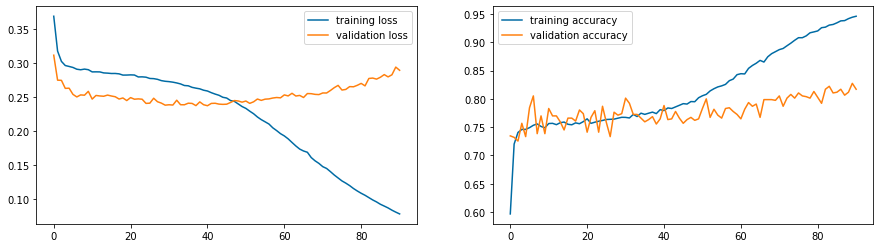

In [0]:
plt.figure(figsize=(15,4))
plt.style.use('tableau-colorblind10')

# Plots of loss curves during training
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()

# Plots of accuracy curves during training
plt.subplot(1,2,2)
plt.plot(history.history['acc'], label="training accuracy")
plt.plot(history.history['val_acc'], label="validation accuracy")
plt.legend()

plt.show()

In [0]:
# Define model
best_model = CNN2b_model(channels=8, filters=10)

# Load best model weights from h5 file
best_model.load_weights(MODEL_LOCATIONS_FILE_PATH + "/model.h5")

# Compile best model model
best_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

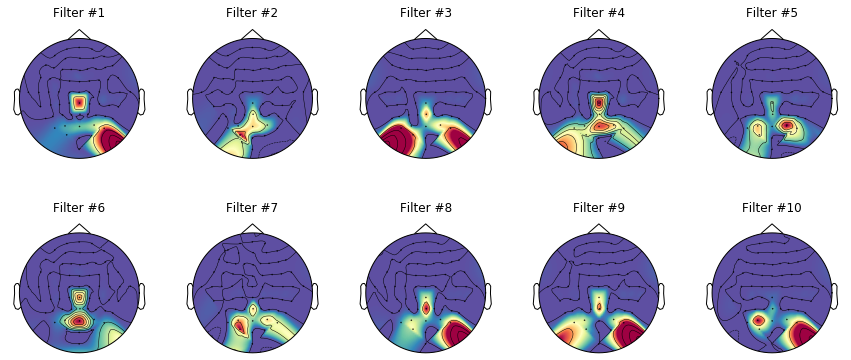

In [0]:
# Load topoplot coordinates
if not os.path.exists(CHANNEL_COORD):
    print("Missing file: {}".format(CHANNEL_COORD))
else:
    xycoord = []
    # Read file content
    with open(CHANNEL_COORD, "r") as f:
        file_content = f.read()
        # Loop over all rows
        for row in file_content.split("\n"): 
        # Skip missing rows
            if row == '':
                continue
            xycoord.append(row)

# Create a list with x,y coordinates of each electrodes well formatted
coord = []
for x in xycoord:
    coord.append(x.split(','))
coord = np.array(coord)

# Flip y axis in order to plot in the right way the electrodes positions
for i in range(len(coord)):
    coord[i][1] = 681 -int(coord[i][1])

# Create a list of weights for all filters
nf = []
for filt in range(10):
    nf.append(abs(np.array(best_model.get_weights()[0])[0, :, filt]))
nf = np.array(nf, dtype=float)

# Add -1 to missing channels values
tmp_full = []
for i in range(10):
    tmp = np.full(64, 0, dtype=float)
    for c in range(N_CHANNELS):
        tmp[CHANNELS[c]] = nf[i][c]
    tmp_full.append(tmp)
nf = np.array(tmp_full, dtype=float)

# Plot topoplot of the 10 filters in the first convolutional layer
fig = plt.figure(figsize=(15,6))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1)
    ax.set_title("Filter #{}".format(i+1))
    mne.viz.plot_topomap(nf[i], coord, cmap='Spectral_r', axes=ax, show=False)

In [0]:
# Accuracy over the testing set
predictions = best_model.predict(test_features)
predictions = np.round(predictions)

score = np.array(best_model.evaluate(test_features, test_labels, verbose=0, sample_weight=test_weights))
print("Model performance on test set:\t[ Loss: {}\tAccuracy: {} ]".format(*score.round(4)))
print("\nPredictions: {}\nSolutions:   {}".format(list(map(int, predictions))[:50], list(map(int, test_labels))[:50]))

Model performance on test set:	[ Loss: 0.3895	Accuracy: 0.7731 ]

Predictions: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]
Solutions:   [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]


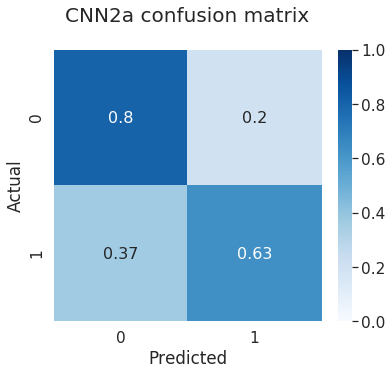

In [0]:
# Weighted confusion matrix (noP300: 80%, P300: 20%)
data = confusion_matrix(y_true=test_labels, y_pred=predictions, sample_weight=test_weights)

# Normalized confusion matrix (values in range 0-1)
data_norm = data/np.full(data.shape, len(test_labels))

# Plot the confusion matrix
df_cm = pd.DataFrame(data_norm, columns=np.unique(test_labels), index = np.unique(test_labels))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,5))
sns.set(font_scale = 1.4)
cm = sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws = {"size": 16}, vmin=0, vmax=1)
cm.axes.set_title("CNN2a confusion matrix\n", fontsize=20)
plt.show()

In [0]:
# Model metrics (sens, spec, ppv, npv)
def model_metrics(conf_matrix):
    tn, fp, fn, tp = list(data_norm.flatten())
    sens = round(tp/(tp+fn),4) # Sensitivity
    spec = round(tn/(tn+fp),4) # Specificity
    ppv = round(tp/(tp+fp),4) # Positive Predicted Value
    npv = round(tn/(tn+fn),4) # Negative Predicted Value
    return {"Sensitivity":sens, "Specificity":spec, "PPV":ppv, "NPV":npv}

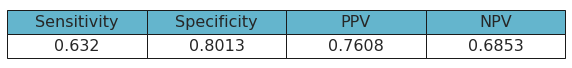

In [0]:
# Put model metrics into a table
metrics = model_metrics(data_norm)

# Create figure
fig = plt.figure(figsize=(5,1))
ax = fig.add_subplot(111)

# Hide graph outlines
for item in [fig, ax]:
    item.patch.set_visible(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

# Table definition
table = ax.table(cellText=[list(metrics.values())], 
                     colLabels=list(metrics.keys()),
                     loc="center",
                     cellLoc="center",
                     colColours=["c"]*4)
table.set_fontsize(16)
table.scale(2,2)

plt.show()